In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# I am familiarizing myself with the matplotlib.pylot library, 
# so it is the only plotting library I will be using in this project.

import random
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

# Import and Prep Data

In [2]:
feature_data = pd.read_csv('data/train_features.csv')
salary_data = pd.read_csv('data/train_salaries.csv')

In [3]:
feature_data.head() #take a look at the features

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


<span style="color:blue">There are 8 variables - 6 categorical and 2 numerical. <br >
_jobId_ might uniquely identify each row of data, so it might be excluded when fitting models.</span>

In [4]:
salary_data.head() # take a look at the target data

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


<span style = "color:blue"> This might seem obvious, but the numerical target value indicates we should attempt to fit some type of regression model. <br >
Next, join the features with the target variable to ensure that the correct salary is associated with each set row.</span>

In [5]:
# join the features data with the target variable(salary), 
# the join will be done on the jobId column
all_data = feature_data.merge(salary_data, how = 'inner', on='jobId',validate='1:1')
# we're doing an inner join, because we can only use data where both the target and feature variables are available

In [6]:
all_data.head() # check that the join was done properly and the dataset looks fine

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


<span style="color:blue"> 
scikit-learn has a library that will split data into test and training sets, but here's my simple implementation:
</span>

In [7]:
TEST_PERCENT = 0.2 # percent of dataset that will be the test set

#create a list of integers that is TEST_PERCENT *length of the dataset, 
#which will be the rows that end up in the test dataset
test_index = random.sample(range(len(all_data)),int(len(all_data)*TEST_PERCENT))
#random.sample samples without replacement, so this should be a unique list

# create a second list of intgers that are not in the test set, these will be for the training set
train_index = np.setdiff1d(np.arange(0,len(all_data)), test_index)

# create the two sets, based on the two lists above
all_data_test = all_data.iloc[test_index]
all_data_train = all_data.iloc[train_index]

In [8]:
len(all_data_train) #check that we have the appropriate amount of data in the training set

800000

In [9]:
len(all_data_test) #check that we have the appropriate amount of data in the test set

200000

In [10]:
all_data['jobId'].nunique()

1000000

<span style="color:blue">The jobIds are unique, so we'll assume that every row of data is unique. This means the _jobId_ column will need to be excluded when fitting the model, which might then cause duplicates in the data. This is not necessarily a problem, but it's something to keep in mind if we see odd predictions from the models.</span>

# Exploratory Data Analysis

<span style="color:blue">Take a look at the features, using various matplotlib charts.</span>

<span style="color:blue">**companyId** </span>

In [11]:
all_data_train['companyId'].nunique()

63

<span style = "color:blue"> There are 63 different companies. Let's see what the distribution is: </span>

In [12]:
all_data_train['companyId'].value_counts().sort_values() #visual might be better here

COMP2     12492
COMP29    12534
COMP8     12538
COMP33    12549
COMP0     12550
          ...  
COMP42    12863
COMP44    12872
COMP35    12878
COMP40    12883
COMP39    12979
Name: companyId, Length: 63, dtype: int64

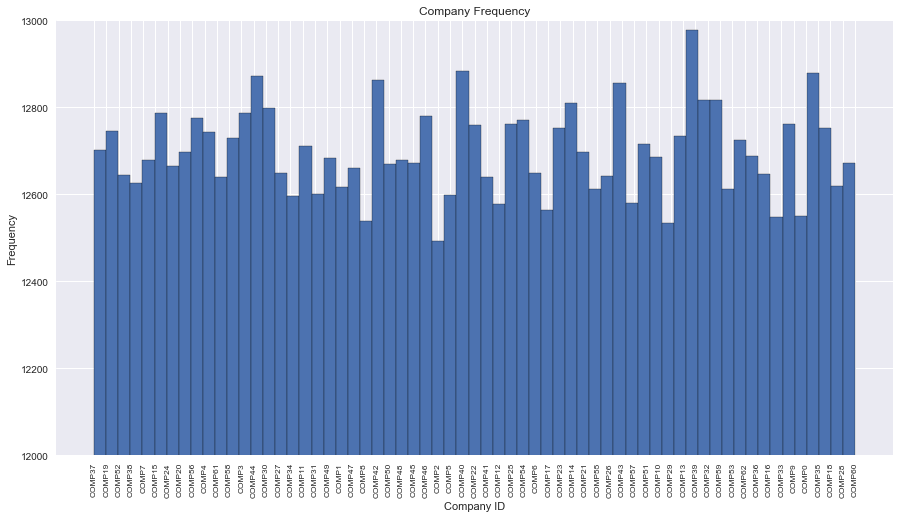

In [92]:
plt.style.use('seaborn')

plt.figure(figsize = (15,8))
plt.hist(all_data_train['companyId'], bins = 63, edgecolor = 'black')
plt.title('Company Frequency')
plt.xlabel('Company ID')
plt.ylabel('Frequency')
plt.ylim(12000,13000)
plt.xticks(rotation=90,fontweight='medium',fontsize='small')
plt.show() # hist displays without this, but this gets rid of all of the extra data

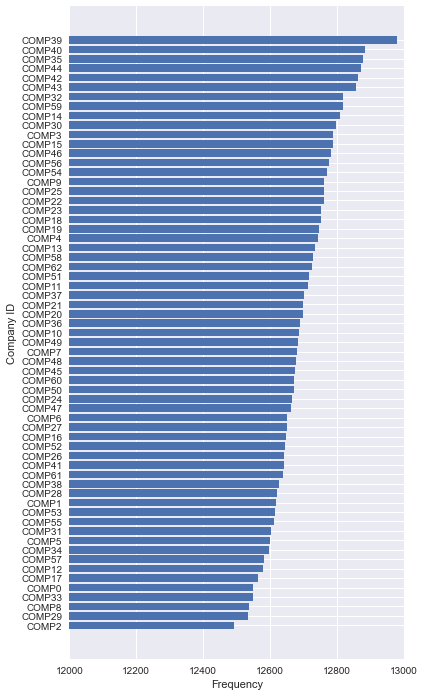

In [95]:
# another way to look at it
fig, ax = plt.subplots(figsize = (6,12))
ax.barh(all_data_train['companyId'].value_counts().sort_values().index,all_data_train['companyId'].value_counts().sort_values())
ax.set_xlim(12000,13000)
ax.set_ylabel('Company ID')
ax.set_xlabel('Frequency')
plt.show()

<span style="color:blue">Each company appears between 12400 and 13000 times.</span>

<span style="color:blue">**jobType**</span>

In [16]:
all_data_train['jobType'].nunique()

8

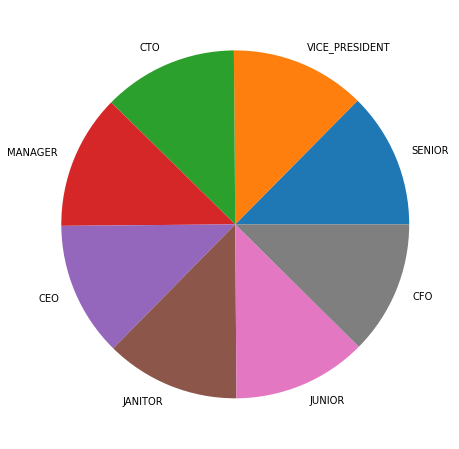

In [17]:
fig, ax = plt.subplots(figsize = (8,8))
plt.pie(all_data_train['jobType'].value_counts(), labels = all_data_train['jobType'].value_counts().index)
plt.show()

<span style="color:blue">There are 8 job types in the dataset, all of which seem to be represented equally, but let's make sure:</span>

In [18]:
all_data_train['jobType'].value_counts()/len(all_data_train)

SENIOR            0.125906
VICE_PRESIDENT    0.125339
CTO               0.125170
MANAGER           0.124976
CEO               0.124930
JANITOR           0.124799
JUNIOR            0.124611
CFO               0.124269
Name: jobType, dtype: float64

<span style="color:blue">Each jobType appears about 12.5% of the time, this dataset definetely seems engineered. </span>

<span style="color:blue">Is there a correlation between jobType and salary? </span>

In [20]:
all_data_train.groupby(['jobType']).mean()['salary']

jobType
CEO               145.342172
CFO               135.295318
CTO               135.524267
JANITOR            70.794960
JUNIOR             95.375357
MANAGER           115.437173
SENIOR            105.538585
VICE_PRESIDENT    125.313500
Name: salary, dtype: float64

<span style = "color:blue">^There _is_ a variation in the average salary per job type. </span>

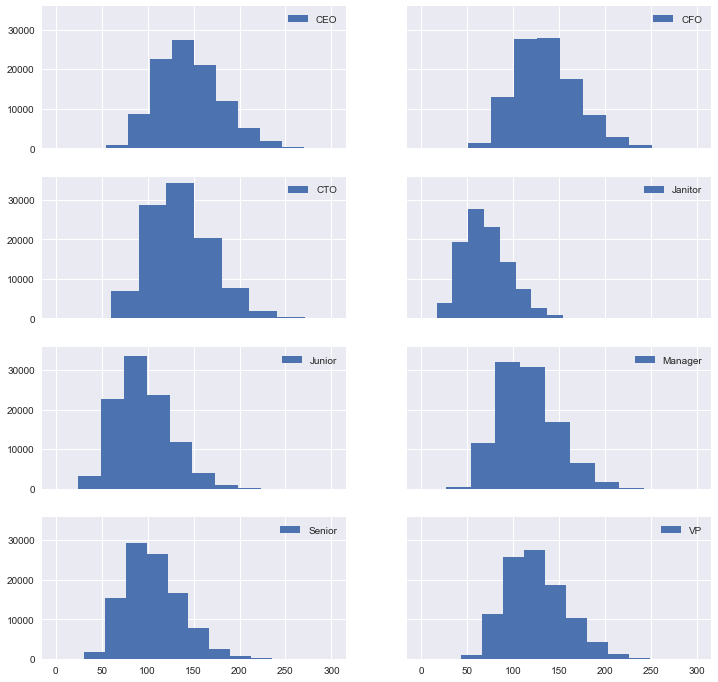

In [21]:
# plot salary by jobType

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,2,figsize=(12,12),sharex=True,sharey=True)

ax1[0].hist(all_data_train[all_data_train['jobType'] == 'CEO']['salary'], label = 'CEO')
ax1[1].hist(all_data_train[all_data_train['jobType'] == 'CFO']['salary'], label = 'CFO')
ax2[0].hist(all_data_train[all_data_train['jobType'] == 'CTO']['salary'], label = 'CTO')
ax2[1].hist(all_data_train[all_data_train['jobType'] == 'JANITOR']['salary'], label = 'Janitor')
ax3[0].hist(all_data_train[all_data_train['jobType'] == 'JUNIOR']['salary'], label = 'Junior')
ax3[1].hist(all_data_train[all_data_train['jobType'] == 'MANAGER']['salary'], label = 'Manager')
ax4[0].hist(all_data_train[all_data_train['jobType'] == 'SENIOR']['salary'], label = 'Senior')
ax4[1].hist(all_data_train[all_data_train['jobType'] == 'VICE_PRESIDENT']['salary'], label = 'VP')
ax1[0].legend()
ax1[1].legend()
ax2[0].legend()
ax2[1].legend()
ax3[0].legend()
ax3[1].legend()
ax4[0].legend()
ax4[1].legend()
plt.show()

<span style = "color:blue">
    C-level, Manager, and VP have a wider range and the highest maximums. The janitor's salary range is on the lower end. The bulk of the C-level job salaries are greater than the Senior and Manager, but the ranges aren't that different, which is surprising. </span>

<span style="color:blue">**degree**</span>

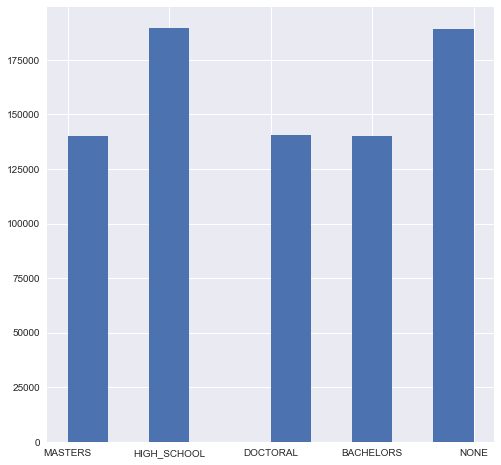

In [23]:
fig, ax = plt.subplots(figsize = (8,8))
ax.hist(all_data_train['degree'])
plt.show()

<span style="color:blue">
    More people in this dataset hold degrees than do not, and it is evenly split between the three degree types. High School and no degree are about equal.
</span>

<span style="color:blue">**major**</span>

In [26]:
all_data_train['major'].value_counts()

NONE           425785
CHEMISTRY       47068
ENGINEERING     46943
LITERATURE      46895
BUSINESS        46852
COMPSCI         46809
PHYSICS         46668
BIOLOGY         46622
MATH            46358
Name: major, dtype: int64

<span style="color:blue">
    About half of the data points have no major, and the other half are about equally split at around 47000.
</span>

In [29]:
#majors by degree type
all_data_train[['major','degree']].value_counts()

major        degree     
NONE         HIGH_SCHOOL    189758
             NONE           189279
PHYSICS      MASTERS         15745
LITERATURE   DOCTORAL        15740
ENGINEERING  BACHELORS       15737
CHEMISTRY    MASTERS         15706
             BACHELORS       15686
NONE         DOCTORAL        15681
CHEMISTRY    DOCTORAL        15676
COMPSCI      BACHELORS       15674
BUSINESS     DOCTORAL        15670
LITERATURE   MASTERS         15655
BUSINESS     MASTERS         15624
ENGINEERING  DOCTORAL        15607
BIOLOGY      DOCTORAL        15602
ENGINEERING  MASTERS         15599
COMPSCI      MASTERS         15580
NONE         BACHELORS       15570
BUSINESS     BACHELORS       15558
BIOLOGY      BACHELORS       15558
COMPSCI      DOCTORAL        15555
PHYSICS      DOCTORAL        15547
LITERATURE   BACHELORS       15500
NONE         MASTERS         15497
MATH         DOCTORAL        15484
             BACHELORS       15462
BIOLOGY      MASTERS         15462
MATH         MASTERS         1

<span style="color:blue">Of the degree holders, there are around 15.5K in each major.</span>

<span style="color:blue">Let's look at salary by degree:</span>

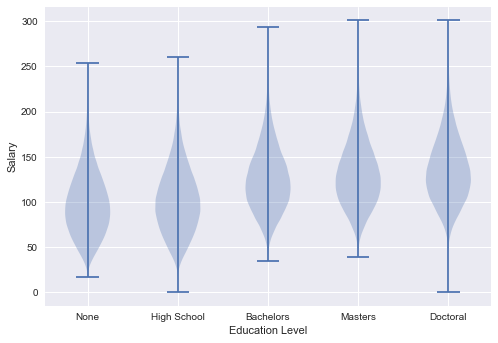

In [30]:
#salary by degree comparison
degree_none = all_data_train[all_data_train['degree'] == 'NONE']['salary']
degree_hs = all_data_train[all_data_train['degree'] == 'HIGH_SCHOOL']['salary']
degree_bach = all_data_train[all_data_train['degree'] == 'BACHELORS']['salary']
degree_master = all_data_train[all_data_train['degree'] == 'MASTERS']['salary']
degree_phd = all_data_train[all_data_train['degree'] == 'DOCTORAL']['salary']

fig, ax = plt.subplots()
ax.violinplot([degree_none,degree_hs,degree_bach,degree_master,degree_phd])
ax.set_xlabel('Education Level')
ax.set_ylabel('Salary')
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(['None','High School','Bachelors','Masters','Doctoral'])
plt.show()

<span style="color:blue">
    All distributions have about the same shape. The widest range in salary occurs with the Doctoral degree, including salaries of zero. The maximums of Masters and Doctoral are about the same.
</span>

<span style="color:blue">**industry**</span>

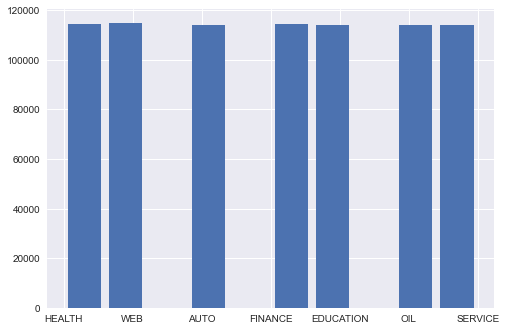

In [32]:
fig, ax = plt.subplots()
ax.hist(all_data_train['industry'], rwidth = 0.8)
plt.show()

<span style="color:blue"> The data is pretty evenly distributed across industries. </span>

<span style="color:blue">**yearsExperience**</span>

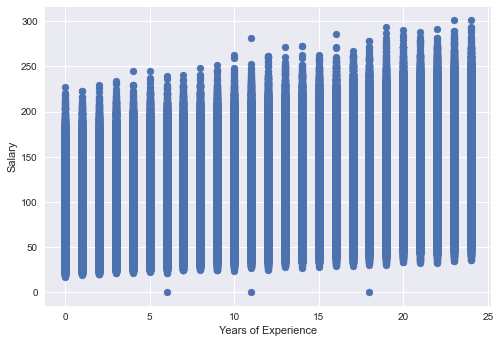

In [34]:
fig, ax = plt.subplots()
ax.scatter(all_data_train['yearsExperience'],all_data_train['salary'])
ax.set_xlabel('Years of Experience')
ax.set_ylabel('Salary')
plt.show()

<span style="color:blue">Range is 0 to 24. Small increases in the minimums and maximums as the years increase.</span>

<span style="color:blue">There are some $0 salaries:</span>

In [35]:
all_data_train[all_data_train['salary']==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0


<span style="color:blue">Considering there are 800000 data points, we might be okay leaving these in for now.</span>

<span style="color:blue">Almost any chart would be better than this, but I'll throw in a pie chart to change things up.</span>

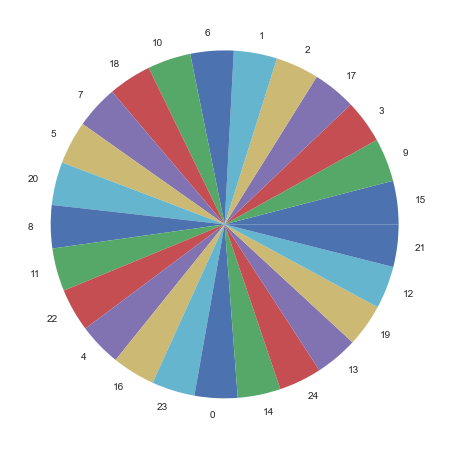

In [36]:
fig, ax = plt.subplots(figsize = (8,8))
plt.pie(all_data_train['yearsExperience'].value_counts(), labels = all_data_train['yearsExperience'].value_counts().index)
plt.show()

In [37]:
all_data_train[['yearsExperience','salary']].corr()

,yearsExperience,salary
yearsExperience,1.000000,0.374379
salary,0.374379,1.000000


<span style = "color:blue">
    The linear correlation between years of experience and salary is low.
</span>

<span style = "color:blue">**miles from Metro**</span>

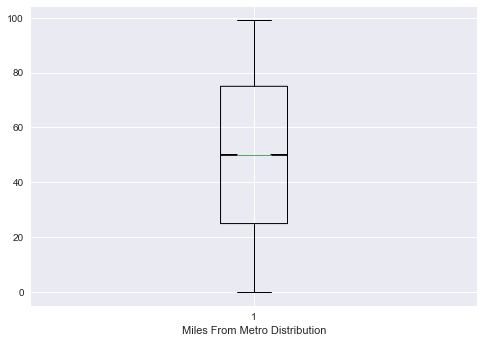

In [38]:
fig, ax = plt.subplots()
ax.boxplot(all_data_train['milesFromMetropolis'], notch=True)
ax.set_xlabel('Miles From Metro Distribution')
plt.show()

<span style = "color:blue">
    The median is about 50 miles from metropolis, with 50% of the data falling in the approximate range of 25 to 75 miles. There are outliers of 0 and 100 miles. 
</span>

<span style = "color:blue">**salary**</span>

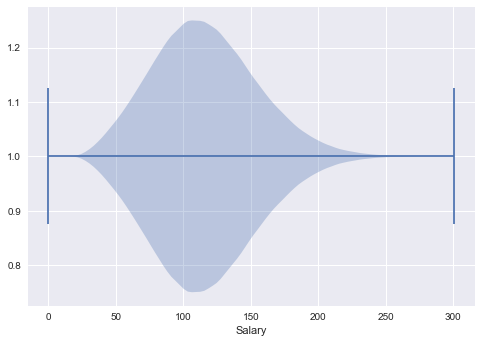

In [40]:
fig, ax = plt.subplots()
ax.violinplot(all_data_train['salary'],vert = False)
ax.set_xlabel('Salary')
plt.show()

<span style="color:blue">**Data Summary** <br />
companyId - 63 unique, range  for each is 12750-13250 <br />
jobType - 8 unique, each is about 12.5% of total <br />
degree - high school and none are at about 190K, bachelor's, master's, doctoral at about 140K <br />
major - about half have no major listed, the other half are evenly split at around 47K <br />
industry - evenly distributed across all industries, around 119K <br />
yearsExperience - ranges from 0 to 24, data is pretty evenly split among the years <br />
milesfromMetropolis - median is 50, range is 0 to 100, 50% of data is between 25 and 75 miels <br />
salary - normal looking distribution, but right tail is slightly longer than left, mode is between 100 and 125
    </span>

# One hot encoding categorial variables

In [41]:
# companyId, jobType, degree, major, industry

In [42]:
all_data_train_enc = pd.get_dummies(all_data_train, prefix = ['co','job','deg','mjr','ind'], columns = ['companyId','jobType','degree','major','industry'], drop_first = True)

In [43]:
all_data_train_enc

,jobId,yearsExperience,milesFromMetropolis,salary,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
0,JOB1362684407687,10,83,130,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,JOB1362684407688,3,73,101,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,JOB1362684407689,10,38,137,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,8,17,142,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,8,16,163,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999993,JOB1362685407680,4,6,136,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
999994,JOB1362685407681,18,77,115,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
999996,JOB1362685407683,12,35,160,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
999997,JOB1362685407684,16,81,64,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


# Fit Linear Regression Model

<span style="color:blue">First we'll try linear regression on all of the varables (except for jobId).</span>

In [44]:
lm = LinearRegression()

In [45]:
y = all_data_train_enc[['salary']]
x = all_data_train_enc.iloc[:,1:] # remove jobId column
x = x.drop(labels = 'salary',axis = 1)

In [46]:
x.head()  

,yearsExperience,milesFromMetropolis,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,co_COMP15,co_COMP16,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
0,10,83,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,3,73,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10,38,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,8,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,16,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [47]:
lm.fit(x,y)

LinearRegression()

# Transform Test Set to Match Training Set

<span style="color:blue">We need to create the dummy variables for the companyId, jobType, degree, major, and industry columns: </span>

In [48]:
all_data_test.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
343027,JOB1362684750714,COMP13,SENIOR,BACHELORS,MATH,EDUCATION,4,36,98
270351,JOB1362684678038,COMP37,VICE_PRESIDENT,MASTERS,COMPSCI,SERVICE,0,5,118
55164,JOB1362684462851,COMP0,CFO,DOCTORAL,ENGINEERING,EDUCATION,12,96,145
756004,JOB1362685163691,COMP50,CFO,HIGH_SCHOOL,NONE,FINANCE,12,6,151
366549,JOB1362684774236,COMP14,VICE_PRESIDENT,HIGH_SCHOOL,NONE,AUTO,2,47,66


In [49]:
all_data_test_enc = pd.get_dummies(all_data_test, prefix = ['co','job','deg','mjr','ind'], columns = ['companyId','jobType','degree','major','industry'], drop_first = True)

In [50]:
all_data_test_enc.head()

,jobId,yearsExperience,milesFromMetropolis,salary,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
343027,JOB1362684750714,4,36,98,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
270351,JOB1362684678038,0,5,118,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
55164,JOB1362684462851,12,96,145,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
756004,JOB1362685163691,12,6,151,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
366549,JOB1362684774236,2,47,66,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [51]:
y_test = all_data_test_enc[['salary']]

In [52]:
print(len(y_test))
y_test.head()

200000


,salary
343027,98
270351,118
55164,145
756004,151
366549,66


In [53]:
x_test = all_data_test_enc.iloc[:,1:] # remove jobID column
x_test = x_test.drop(labels = 'salary', axis = 1) #remove salary column
x_test.head()

,yearsExperience,milesFromMetropolis,co_COMP1,co_COMP10,co_COMP11,co_COMP12,co_COMP13,co_COMP14,co_COMP15,co_COMP16,...,mjr_LITERATURE,mjr_MATH,mjr_NONE,mjr_PHYSICS,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB
343027,4,36,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
270351,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
55164,12,96,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
756004,12,6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
366549,2,47,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


# Prediction & Model Assessment

In [54]:
predictions = lm.predict(x_test)

In [55]:
predictions

array([[ 84.13670459],
       [116.72828647],
       [121.16515549],
       ...,
       [132.216596  ],
       [ 67.66001367],
       [ 93.36725118]])

In [56]:
len(predictions)#check

200000

In [58]:
residuals = np.array(y_test) - predictions
residuals

array([[ 13.86329541],
       [  1.27171353],
       [ 23.83484451],
       ...,
       [-29.216596  ],
       [  9.33998633],
       [ 18.63274882]])

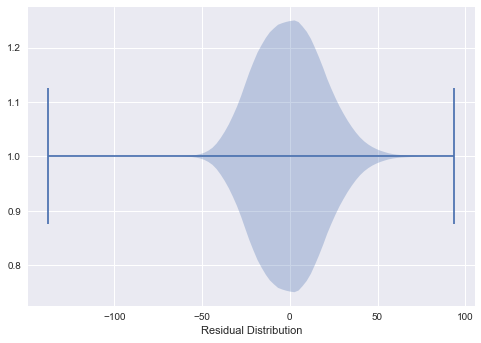

In [59]:
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals, vert = False)
ax.set_xlabel('Residual Distribution')
plt.show()

<span style = "color:blue">The residuals seem to be normally distributed, which is a good sign.<br >
Let's plot the actual salaries and the predicted salaries to see how the model did:
</span>

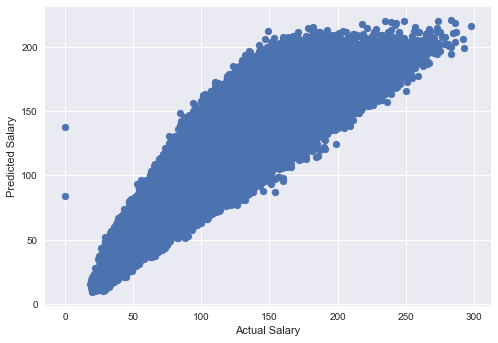

In [60]:
# actual vs predicted
fig, ax = plt.subplots()
ax.scatter(np.array(y_test),predictions)
ax.set_xlabel('Actual Salary')
ax.set_ylabel('Predicted Salary')
plt.show()

<span style = "color:blue">The relationship between actual and predicted looks fairly linear, though the spread might be wider than we want.<br >
Let's look at the equation for the linear regression line:
</span>

In [61]:
lm.intercept_

array([134.57367831])

In [62]:
lm.coef_

array([[ 2.00959000e+00, -3.99198625e-01,  2.99888441e-02,
         5.10740788e-01,  4.29926358e-01,  1.81044780e-01,
         6.12042448e-01,  2.98887999e-01,  3.23168304e-01,
         1.89174047e-01,  4.41008368e-01,  5.77346887e-02,
         3.60197430e-01,  6.83101002e-01,  7.80471053e-02,
         5.02436980e-01,  4.46079097e-01,  1.90115829e-01,
         4.05664626e-01,  5.09932980e-01,  3.85117697e-01,
         4.72039685e-01,  5.51252112e-01,  3.93960311e-01,
         4.05041577e-01, -8.83792581e-02,  2.59683873e-01,
         2.34074729e-01,  5.38239862e-01,  3.79145146e-01,
         3.42268473e-01,  3.02373126e-01,  6.87308998e-03,
         2.27363557e-01,  1.05015334e-01,  5.16398117e-01,
         7.30310738e-01,  5.35401535e-01,  2.10294527e-01,
         1.96296527e-01,  5.91260447e-01,  2.98142295e-01,
         3.72597667e-01,  1.11603187e-01,  1.93331709e-02,
         4.01543809e-01,  2.68029905e-01,  3.00593758e-01,
         3.56751100e-01,  5.38496380e-01, -8.67954984e-0

<span style = "color:blue">Let's find the largest absolute coefficient and what variable it corresponds to: </span>

In [117]:
np.absolute(lm.coef_).max()#largest abs coefficient

62.43083008229509

In [133]:
x.columns[np.where(np.absolute(lm.coef_) == np.absolute(lm.coef_).max())[1][0]]#variable

'job_JANITOR'

<span style = "color:blue">If all other variables are held constant, and _job_JANITOR_ is changed from 0 to 1, it results in a $62.43 decrease in predicted salary. <br >
Evaluate the model:</span>

In [63]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions))
print('MSE: ',metrics.mean_squared_error(y_test, predictions))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions)))

MAE:  15.835063582348416
MSE:  384.4680950924004
RMSE:  3.9793295393003603


# Model 2 - Without company ID

In [64]:
x2 = x.filter(regex = '^[^co_.*]')
lm2 = LinearRegression()
lm2.fit(x2,y)

LinearRegression()

In [65]:
x_test2 = x_test.filter(regex = '^[^co.*]')
predictions2 = lm2.predict(x_test2)

In [66]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions2))
print('MSE: ',metrics.mean_squared_error(y_test, predictions2))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions2)))

MAE:  15.833113366477239
MSE:  384.3974688023827
RMSE:  3.979084488481897


In [67]:
#not much improvement, but this means we can drop the companyId data

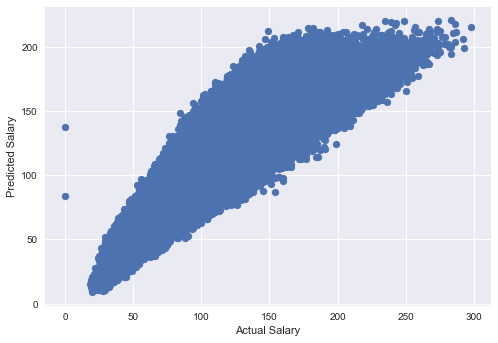

In [68]:
# actual vs predicted
fig, ax = plt.subplots()
ax.scatter(np.array(y_test),predictions2)
ax.set_xlabel('Actual Salary')
ax.set_ylabel('Predicted Salary')
plt.show()

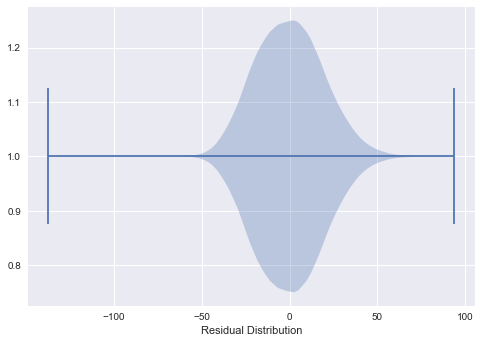

In [69]:
residuals2 = np.array(y_test) - predictions2
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals2, vert = False)
ax.set_xlabel('Residual Distribution')
plt.show()

# Model 3 - Gradient Boost

In [70]:
gbm = GradientBoostingRegressor(criterion = 'mse')
# use default learning rate of 0.1 and 100 estimators, least squares loss function
# but use mse, and read up on friedman mse

In [71]:
gbm.fit(x,np.array(y).ravel())

GradientBoostingRegressor(criterion='mse')

In [72]:
predictions3 = gbm.predict(x_test)

In [73]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions3))
print('MSE: ',metrics.mean_squared_error(y_test, predictions3))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions3)))

MAE:  15.90758374235309
MSE:  392.6971615456729
RMSE:  3.9884312382631206


In [74]:
# this model has larger MAE and MSE than the other two

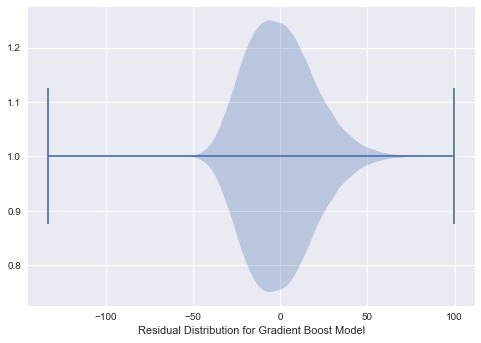

In [75]:
residuals3 = np.array(y_test).ravel() - predictions3
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals3, vert = False)
ax.set_xlabel('Residual Distribution for Gradient Boost Model')
plt.show()

# Model 4 - Gradient Boost with default criterion setting (Friedman's MSE)

In [76]:
gbm2 = GradientBoostingRegressor()
# use default learning rate of 0.1 and 100 estimators, least squares loss function

In [77]:
gbm2.fit(x,np.array(y).ravel())

GradientBoostingRegressor()

In [78]:
predictions4 = gbm2.predict(x_test)

In [79]:
print('MAE: ',metrics.mean_absolute_error(y_test, predictions4))
print('MSE: ',metrics.mean_squared_error(y_test, predictions4))
print('RMSE: ',np.sqrt(metrics.mean_absolute_error(y_test, predictions4)))

MAE:  15.9075837423531
MSE:  392.6971615456735
RMSE:  3.988431238263122


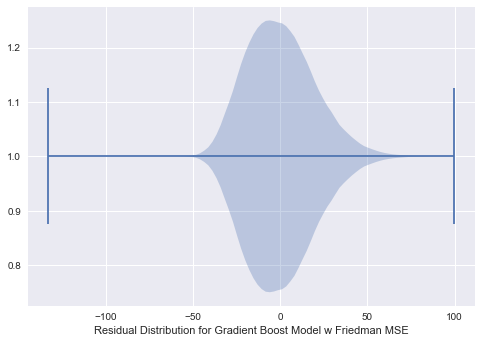

In [80]:
residuals4 = np.array(y_test).ravel() - predictions4
#plot residuals
fig, ax = plt.subplots()
ax.violinplot(residuals4, vert = False)
ax.set_xlabel('Residual Distribution for Gradient Boost Model w Friedman MSE')
plt.show()

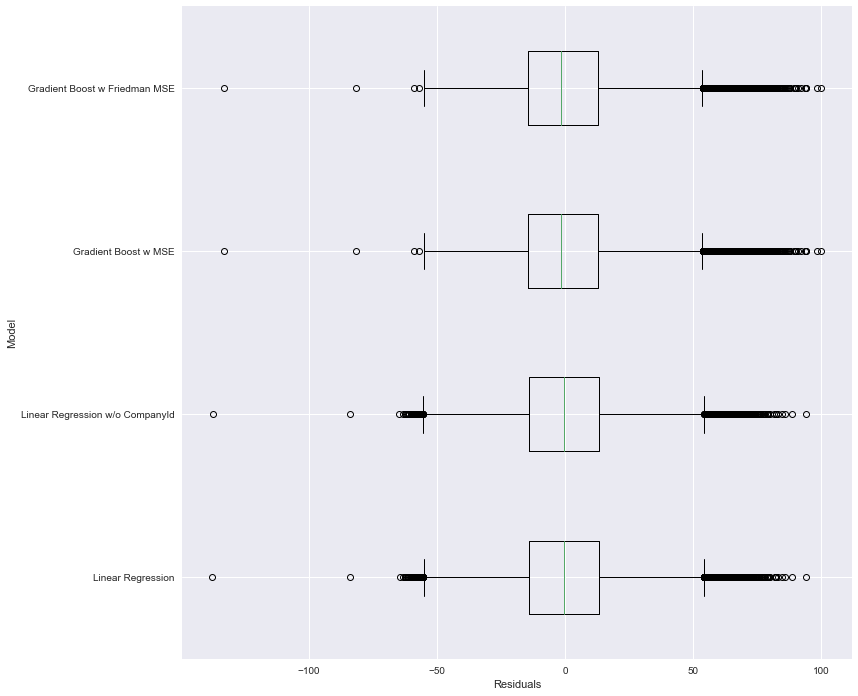

In [81]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.boxplot([residuals.ravel(),residuals2.ravel(),residuals3.ravel(),residuals4.ravel()], vert = False)
ax.set_ylabel('Model')
ax.set_xlabel('Residuals')
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(['Linear Regression','Linear Regression w/o CompanyId','Gradient Boost w MSE','Gradient Boost w Friedman MSE'])
plt.show()